In [31]:
import os
import sys
sys.path.append(os.getcwd())
import utils

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve, auc ,accuracy_score,precision_score,recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [32]:
final_df = pd.read_pickle("../data/processed_data.pkl")

In [33]:
#Splitting the data into required data frames for modelling
final_df_model = final_df.drop(columns = ["Median GRPS Score"])
train_split, test_split = train_test_split(final_df_model, test_size = 0.2, random_state = 42, shuffle = True)
df_train_features = train_split
df_test_features = test_split
df_train_target = df_train_features["Runner_Class"]
df_test_target = df_test_features["Runner_Class"]
df_train_features_numeric = df_train_features.select_dtypes(include=[int, float])
df_test_features_numeric = df_test_features.select_dtypes(include=[int, float])
#print(df_train_features.info())
#print(df_test_features)
#print(df_train_target)
#print(df_test_target)

**1st classification method - Manual Desicion Tree**
Based on the data, "Calculated Pace" appears to be the feature that most clearly separates the different classes. This led us to assign it the highest importance in our manually constructed decision tree. Subsequently, I attempted to further distinguish the classes using "Average HR" and "Distance."

In [34]:
def decision_tree_rules(runner_row):
    if runner_row["Median Calculated Pace"] >= 6.05:
        return "Beginner"
    elif runner_row["Median Calculated Pace"] <= 5.1:
        if runner_row["Median Distance"] >= 13:
            return "Advanced"
        elif runner_row["Median Avg HR"]<= 152:
            return "Advanced"
        else:
            return "Intermediate"
    elif runner_row["Median Calculated Pace"] <=6.05:
        if 120 <= runner_row["Median Avg HR"] <= 165:
            return "Intermediate"
        elif runner_row["Median Avg HR"] <= 120:
            return "Advanced"
    return "Beginner"

res_test = df_test_features.apply(decision_tree_rules, axis=1)
res_train = df_train_features.apply(decision_tree_rules, axis=1)

In [35]:
#Accuracy test split:
result_test = df_test_target == res_test
count_T_and_F = result_test.value_counts()
accuracy = count_T_and_F[True] / len(res_test)
print("Test Accuracy:", accuracy)
print(count_T_and_F)

#Accuracy train split:
result_train = df_train_target == res_train
count_T_and_F = result_train.value_counts()
accuracy = count_T_and_F[True] / len(res_train)
print("Train Accuracy:", accuracy)
print(count_T_and_F)

Test Accuracy: 0.7931034482758621
True     46
False    12
Name: count, dtype: int64
Train Accuracy: 0.7763157894736842
True     177
False     51
Name: count, dtype: int64


**1st Method Results**

In [36]:
print("Classification report - manual Decision Tree:")
print(classification_report(df_test_target, res_test))

Classification report - manual Decision Tree:
              precision    recall  f1-score   support

    Advanced       0.58      0.70      0.64        10
    Beginner       0.87      0.87      0.87        15
Intermediate       0.84      0.79      0.81        33

    accuracy                           0.79        58
   macro avg       0.76      0.78      0.77        58
weighted avg       0.80      0.79      0.80        58



Confusion matrix - manual Decision Tree:


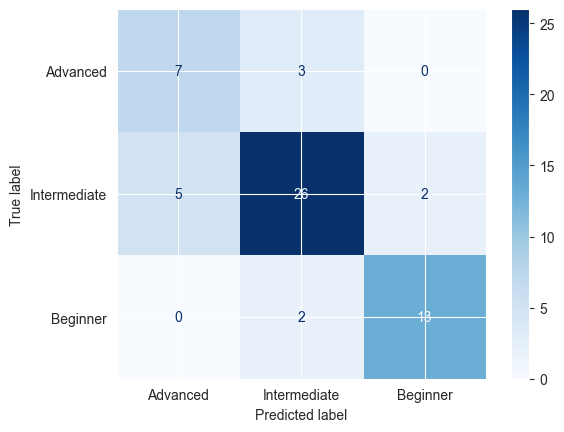

In [37]:
print("Confusion matrix - manual Decision Tree:")
labels_cm = ['Advanced', 'Intermediate', 'Beginner']
cm_DT_manual = confusion_matrix(df_test_target, res_test, labels=labels_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_DT_manual, display_labels=labels_cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**2nd Classification Method - SKL Decision Tree**
Using the decision tree built in function of SKL

In [38]:
sk_tree = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
sk_tree.fit(df_train_features_numeric, df_train_target)

# Predict
y_predict_train_sklearn = sk_tree.predict(df_train_features_numeric)
y_predict_test_sklearn = sk_tree.predict(df_test_features_numeric)

accuracy_train_sklearn = accuracy_score(df_train_target, y_predict_train_sklearn)
accuracy_test_sklearn = accuracy_score(df_test_target, y_predict_test_sklearn)

print("Sklearn Decision Tree Accuracy on train set:", accuracy_train_sklearn)
print("Sklearn Decision Tree Accuracy on test set:", accuracy_test_sklearn)

Sklearn Decision Tree Accuracy on train set: 0.8157894736842105
Sklearn Decision Tree Accuracy on test set: 0.6896551724137931


**2nd Method Results**

In [39]:
print("Classification report - SKL Decision Tree:")
print(classification_report(df_test_target, y_predict_test_sklearn))
#print(classification_report(df_train_target, y_predict_train_sklearn))

Classification report - SKL Decision Tree:
              precision    recall  f1-score   support

    Advanced       0.60      0.30      0.40        10
    Beginner       0.62      1.00      0.77        15
Intermediate       0.76      0.67      0.71        33

    accuracy                           0.69        58
   macro avg       0.66      0.66      0.63        58
weighted avg       0.70      0.69      0.67        58



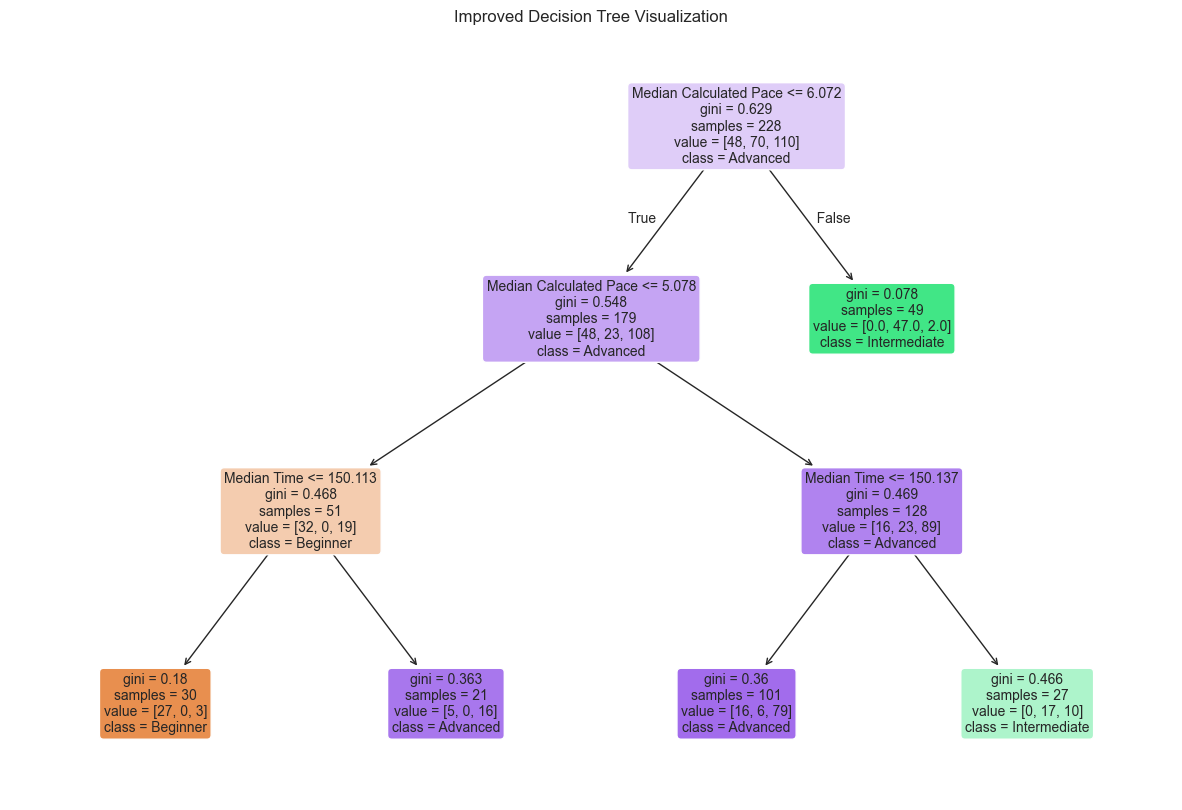

In [40]:
feature_names = ["Median Time", "Median Distance", "Median Avg HR", "Median Calculated Pace", "Median GRPS score"]
class_names = ["Beginner", "Intermediate", "Advanced"]

plt.figure(figsize=(15, 10))
plot_tree(sk_tree,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=10,
          impurity=True,
          node_ids=False,
          proportion=False,
          precision=3)
plt.title("Improved Decision Tree Visualization")
plt.show()

Confusion matrix - SKL Decision Tree:


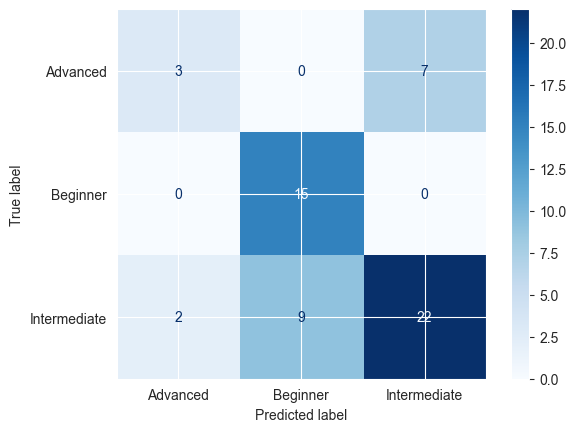

In [41]:
print("Confusion matrix - SKL Decision Tree:")
cm_DT_func = confusion_matrix(df_test_target, y_predict_test_sklearn, labels=sk_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_DT_func, display_labels=sk_tree.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**3rd Method - Logistic Regression**
Using the built in function of SKL and using Cross Validiation to evaluate the performance of the model on unseen sets of data. We should use cross validation to avoid over-fitting and under-fitting, and to get a more reliable estimate of model perfomance.

In [52]:
#df_train_features_numeric_LR = df_train_features_numeric.drop(columns = ["Median Time"])
#df_test_features_numeric_LR = df_test_features_numeric.drop(columns = ["Median Time"])
pipe = Pipeline([('scaler', StandardScaler()),('logreg', LogisticRegressionCV(max_iter=300, random_state=42, l1_ratios=(0,),use_legacy_attributes=True))])
pipe.fit(df_train_features_numeric, df_train_target)
y_pred = pipe.predict(df_test_features_numeric)
coefficients = pd.DataFrame({'Feature': df_train_features_numeric.columns, 'Coefficient': pipe[1].coef_[0]})
print("Model's coefficients:")
print(coefficients)
print("Intercept:", pipe[1].intercept_)

Model's coefficients:
                  Feature  Coefficient
0           Median Avg HR    -5.761652
1         Median Distance     4.952779
2             Median Time    -2.868974
3  Median Calculated Pace   -10.005457
Intercept: [-6.14741252  1.9537813   4.19363122]


**Scaling the data is crucial in Logistic Regression mainly because we want to avoid from the impact of mismatched scale**
**3rd Method Results**

In [43]:
print("Classification report - Logistic Regression:")
print(classification_report(df_test_target, y_pred))
train_pred = pipe.predict(df_train_features_numeric)
test_pred = pipe.predict(df_test_features_numeric)
train_pred_proba = pipe.predict_proba(df_train_features_numeric)
test_pred_proba = pipe.predict_proba(df_test_features_numeric)

train_accuracy = accuracy_score(df_train_target, train_pred)
test_accuracy = accuracy_score(df_test_target, test_pred) ## accuracy - total of True results out of all results (TP + TN / TP + TN + FP + FN)

train_roc_auc = roc_auc_score(df_train_target, train_pred_proba, multi_class='ovr')
test_roc_auc = roc_auc_score(df_test_target, test_pred_proba, multi_class='ovr') #roc_AUC - area under the roc curve

train_precision = precision_score(df_train_target, train_pred, average='weighted')
test_precision = precision_score(df_test_target, test_pred, average='weighted') #Precision - How much of the positive is really positive TP / TP + FP

train_recall = recall_score(df_train_target, train_pred, average='weighted')
test_recall = recall_score(df_test_target, test_pred, average='weighted') #Recall - how much of the positive we have predicted positive TP / TP + FN

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Train ROC AUC:", train_roc_auc)
print("Test ROC AUC:", test_roc_auc)
print("Train Precision:", train_precision)
print("Test Precision:", test_precision)
print("Train Recall:", train_recall)
print("Test Recall:", test_recall)

Classification report - Logistic Regression:
              precision    recall  f1-score   support

    Advanced       0.90      0.90      0.90        10
    Beginner       1.00      1.00      1.00        15
Intermediate       0.97      0.97      0.97        33

    accuracy                           0.97        58
   macro avg       0.96      0.96      0.96        58
weighted avg       0.97      0.97      0.97        58

Train Accuracy: 0.9342105263157895
Test Accuracy: 0.9655172413793104
Train ROC AUC: 0.9887575949865873
Test ROC AUC: 0.9908080808080809
Train Precision: 0.9354427037493399
Test Precision: 0.9655172413793104
Train Recall: 0.9342105263157895
Test Recall: 0.9655172413793104


Confusion matrix - Logistic Regression:


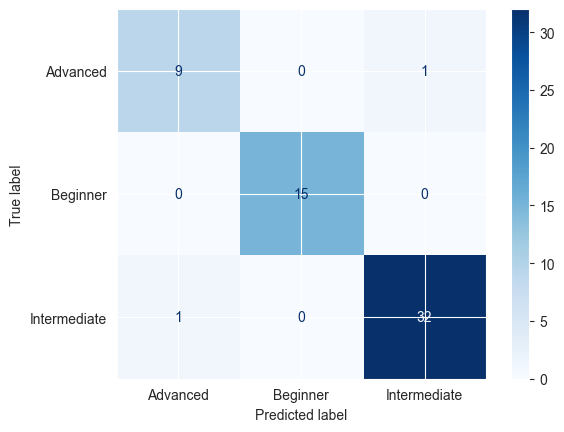

In [44]:
print("Confusion matrix - Logistic Regression:")
cm_LR = confusion_matrix(df_test_target, test_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LR, display_labels=pipe.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**4th Classification Method - Random Forest** - An ensemble of decision trees. Each tree is trained on a bootstrap sample (random subset with replacement). At each split, only a random subset of features is considered.Final prediction = majority vote (classification) or average (regression). This randomness reduces variance (overfitting), while maintaining low bias.
**Advantages** - Handles nonlinear feature interactions well. Robust to outliers & noise. Provides feature importance.
**Cross-val predictions** on training data (for diagnostics) - This process ensures that every data point gets predicted once, but never by a model trained on itself.


In [45]:
# Random forest Pipeline
features = final_df_model.select_dtypes(include=[int, float])
feature_cols = features.columns.tolist()
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(rf_pipe, df_train_features_numeric, df_train_target, cv=cv)
print("CV classification report - Random Forest:")
print(classification_report(df_train_target, y_pred_cv, digits=3))

rf_pipe.fit(df_train_features_numeric, df_train_target)
y_pred_test = rf_pipe.predict(df_test_features_numeric)
print("Test results classification report - Random Forest:")
print(classification_report(df_test_target, y_pred_test, digits=3))

train_accuracy = accuracy_score(df_train_target, y_pred_cv)
test_accuracy = accuracy_score(df_test_target, y_pred_test)

CV classification report - Random Forest:
              precision    recall  f1-score   support

    Advanced      0.878     0.750     0.809        48
    Beginner      0.921     0.829     0.872        70
Intermediate      0.806     0.909     0.855       110

    accuracy                          0.851       228
   macro avg      0.868     0.829     0.845       228
weighted avg      0.857     0.851     0.850       228

Test results classification report - Random Forest:
              precision    recall  f1-score   support

    Advanced      0.778     0.700     0.737        10
    Beginner      0.875     0.933     0.903        15
Intermediate      0.879     0.879     0.879        33

    accuracy                          0.862        58
   macro avg      0.844     0.837     0.840        58
weighted avg      0.860     0.862     0.861        58



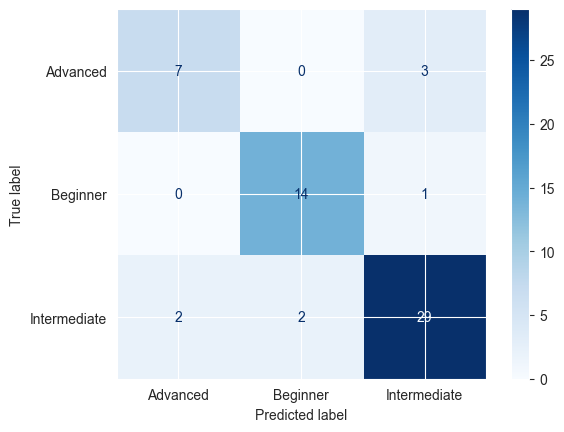

In [46]:
cm = confusion_matrix(df_test_target, y_pred_test, labels=rf_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipe.classes_)
disp.plot(cmap="Blues")
plt.show()

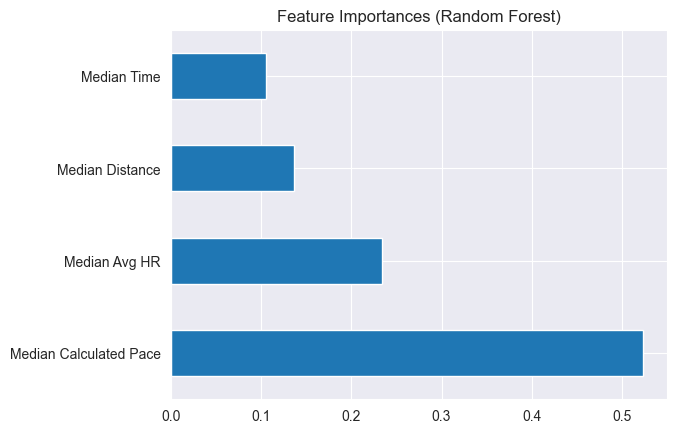

In [47]:
importances = rf_pipe.named_steps["rf"].feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
feat_imp.plot(kind="barh")
plt.title("Feature Importances (Random Forest)")
plt.show()

**Fifth Method - Gradient Boosting** Another ensemble of trees, but instead of training independently (like RF), each new tree is trained to correct the errors of the previous trees.It’s sequential → learns residuals. The model improves gradually, with a learning rate controlling how much each new tree contributes.
**Advantages** - Typically achieves higher accuracy than Random Forest if tuned well. Handles complex nonlinear interactions. More sensitive to hyperparameters (learning_rate, n_estimators, max_depth). Often best for tabular data

In [48]:
#Gradient boosting
gb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    ))
])

y_pred_cv = cross_val_predict(gb_pipe, df_train_features_numeric, df_train_target, cv=cv)
print("CV results - Classification report - Gradient Boosting:")
print(classification_report(df_train_target, y_pred_cv, digits=3))

gb_pipe.fit(df_train_features_numeric, df_train_target)
y_pred_test = gb_pipe.predict(df_test_features_numeric)
print("Test results - Classification report - Gradient Boosting:")
print(classification_report(df_test_target, y_pred_test, digits=3))

train_accuracy = accuracy_score(df_train_target, y_pred_cv)
test_accuracy = accuracy_score(df_test_target, y_pred_test)

CV results - Classification report - Gradient Boosting:
              precision    recall  f1-score   support

    Advanced      0.841     0.771     0.804        48
    Beginner      0.903     0.800     0.848        70
Intermediate      0.795     0.882     0.836       110

    accuracy                          0.833       228
   macro avg      0.846     0.818     0.830       228
weighted avg      0.838     0.833     0.833       228

Test results - Classification report - Gradient Boosting:
              precision    recall  f1-score   support

    Advanced      0.600     0.600     0.600        10
    Beginner      0.933     0.933     0.933        15
Intermediate      0.848     0.848     0.848        33

    accuracy                          0.828        58
   macro avg      0.794     0.794     0.794        58
weighted avg      0.828     0.828     0.828        58



Confusion matrix - Gradient Boosting


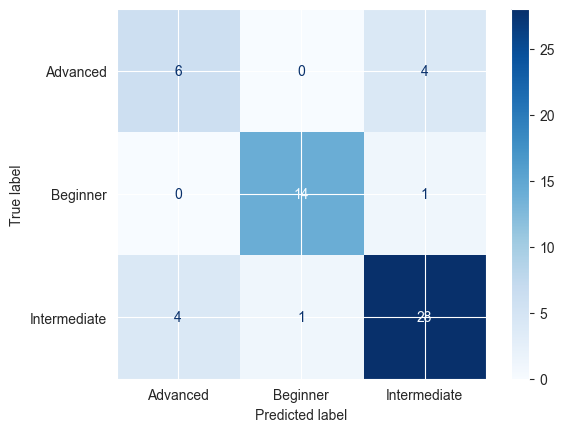

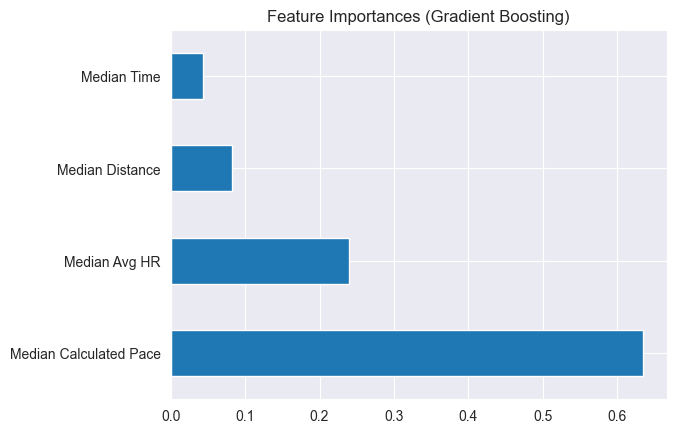

In [49]:
print("Confusion matrix - Gradient Boosting")
cm = confusion_matrix(df_test_target, y_pred_test, labels=gb_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_pipe.classes_)
disp.plot(cmap="Blues")
plt.show()

importances = gb_pipe.named_steps["gb"].feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
feat_imp.plot(kind="barh")
plt.title("Feature Importances (Gradient Boosting)")
plt.show()

In [53]:
results = []
results.append(utils.eval_model(sk_tree, df_train_features_numeric, df_test_features_numeric, df_train_target, df_test_target, "SKL Decision Tree"))
results.append(utils.eval_model(pipe, df_train_features_numeric, df_test_features_numeric, df_train_target, df_test_target, "Logistic Regression"))
results.append(utils.eval_model(rf_pipe, df_train_features_numeric, df_test_features_numeric, df_train_target, df_test_target, "Random Forest"))
results.append(utils.eval_model(gb_pipe, df_train_features_numeric, df_test_features_numeric, df_train_target, df_test_target, "Gradient Boosting"))

results_df = pd.DataFrame(results)

### **Classification Conclusions**

**Model Comparisons**

- **First Method: Building my own decision tree**
  This model demonstrated a mediocre performance on both the train and test sets, with an accuracy between 0.74 and 0.80. The method used to determine the node splits was based on observing the graphs and identifying correlations between the different features and their respective classes.
  We can see that the model had a slight tendency to classify runners as 'Advanced,' which is reflected in its low precision score for that class (it classified 5 'Intermediate' runners as 'Advanced'). This may have occurred due to the similarity of some features in the data (e.g., Average HR, Distance) between the classes.

- **Second Method: Scikit-learn (SKL) Decision Tree**
  This model demonstrated the poorest performance on the test set and showed signs of being overfitted to the training data (train accuracy: 0.82, test accuracy: 0.60).
  Furthermore, the model was effective at identifying 'Beginner' runners but performed poorly on the other classes. We can infer that this occurred because the relatively low pace of the 'Beginner' class allowed the model to find a 'pure' condition to separate the majority of 'Beginner' runners from the rest of the data.

- **Third Method: Logistic Regression Model**
  This model demonstrated the best performance among all models tested. The key features in the regression equation were 'Calculated Pace' and 'Distance,' which led to excellent model performance across all metrics (including accuracy, recall, and precision). Additionally, the model performed consistently well across all classes.

- **Fourth Method: Random Forest**
  The proposed model demonstrated a marginal improvement in performance over a standard decision tree. The slightly reduced performance observed on the training set is a key indicator that the model has avoided overfitting. This model, consistent with the behavior of other decision tree algorithms in this project, achieved its highest performance metrics for the Beginner class.

- **Fifth Method: Gradient Boosting**
  The proposed model exhibited performance metrics nearly identical to those of the Random Forest model. It is important to note that the sample size is small, which means every single misclassification has a significant impact on the overall metrics.
  This model appears to rely heavily on the feature 'Calculated Pace.' Both models achieved their highest performance metrics for the Beginner class.
  Additionally, an analysis of the 'Advanced' class performance suggests the model may have acquired a "wrong" heuristic during training that led to poorer results on the test set, specifically in its ability to accurately classify this group.

**General Conclusions**

- Overall, 'Calculated Pace' had the biggest influence on the classification results, which makes sense since the GRPS score (which determined the label of each runner) was based on the runner's pace (better runners will generally have a better pace).

- Although I initially thought it would have a more significant influence on the different models, 'Average Heart Rate' did not appear to be a significant factor in determining the class of a runner.
  With that said, it has been the second most important feature in Random Forest and Gradient Boosting.

In [51]:
train_split.to_pickle("../data/train_split.pkl")
test_split.to_pickle("../data/test_split.pkl")
results_df.to_pickle("../data/results.pkl")
print("Data saved successfully for sensitivity check and clustering.")

Data saved successfully for sensitivity check and clustering.
